In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from unet.unet import UNet
from randomwalker.RandomWalkerModule import RandomWalker
from data.cremiDataloading import CremiSegmentationDataset
from datapreprocessing.target_sparse_sampling import SparseMaskTransform
from utils.notebookUtils import make_summary_plot, sample_seeds, generate_transforms
from utils.evaluation import compute_iou

## Model Training

In this project, we developed a pretrained model using the entire dataset. The model was trained using the `train.py` script, which encapsulates the training pipeline. It includes functionality for instantiating the dataloader, defining the model architecture, configuring hyperparameters, and training and validating the model using the available data.

#### Model Checkpoints

During training, the script saves the best pretrained model's parameters at every epoch. These checkpoints are stored under the `checkpoints/models` directory. This ensures that you can access the model with the highest performance on the validation set.

To reproduce the pretrained model, follow these steps:

1. Execute the `train.py` script.
2. Monitor the training progress and observe the logs for information on loss, mIoU, and other relevant metrics.
3. Retrieve the pretrained model from the saved checkpoints in the `checkpoints/models` directory.
   
#### Training Configuration

| Argument               | Description                                                        | Default Value |
|------------------------|--------------------------------------------------------------------|---------------|
| `--max-epochs`         | Maximum number of training epochs.                                 | 40            |
| `--batch-size`         | Batch size for training.                                           | 1             |
| `--lr`                 | Learning rate for the optimizer.                                    | 0.001         |
| `--weight-decay`       | Weight decay for regularization.                                    | 0.01          |
| `--patience`           | Patience parameter for early stopping.                             | 3             |
| `--min-delta`          | Minimum change in the monitored quantity for early stopping.       | 0.001         |
| `--load`               | Path to a pre-trained model checkpoint for continuing training.   | False         |
| `--subsampling-ratio`  | Subsampling ratio for creating a sparse mask.                      | 0.5           |
| `--seeds-per-region`   | Number of seeds per region.                                        | 5             |

## Pretrained Model Results with Different Subsampling Ratios

Our study presents the outcomes of three distinct pretrained models, each trained on the complete dataset with subsampling ratios of 0.5, 0.1, and 0.01. These models serve as robust solutions for semantic segmentation tasks. In evaluating their capabilities, we tested the models on inputs of size 512x512, despite being originally trained on a lower resolution of 128x128. This investigation provides valuable insights into the models' adaptability to larger input sizes, highlighting their potential for scalability in diverse scenarios.

In [18]:
def test_pretrained_model(model_path, model_subsampling_ratio, image_size = 128, image_index = 93):
    
    seeds_per_region = 5     # number of seeds provided 
    raw_transforms, target_transforms = generate_transforms(image_size=image_size)
    model = UNet(1, 32, 3)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    rw = RandomWalker(1000, max_backprop=True)

    # load a test observation
    test_dataset = CremiSegmentationDataset("data/sample_A_20160501.hdf", transform=raw_transforms, target_transform=target_transforms, testing=True)
    test_raw, test_segmentation, test_mask = test_dataset[image_index]

    # determine number of segments in the image
    num_classes = len(np.unique(test_segmentation.squeeze()))

    # sample some amount of seeds from each segment
    seeds = sample_seeds(seeds_per_region, test_segmentation, num_classes)

    # compute UNet output
    net_output = model(test_raw.unsqueeze(0))
    diffusivities = torch.sigmoid(net_output)
    # RW given the diffusivities from UNet
    output = rw(diffusivities, seeds)

    # compute fit metrics (mIoU)
    pred_masks = torch.argmax(output[0], dim=1)
    iou_score = compute_iou(pred_masks.detach().cpu(), test_segmentation.detach().cpu(), num_classes)

    # make_summary_plot(0, test_raw, output, diffusivities, seeds, test_segmentation, iou_score, model_subsampling_ratio)
    make_summary_plot(0, test_raw, output, diffusivities, seeds, test_segmentation, iou_score, model_subsampling_ratio)

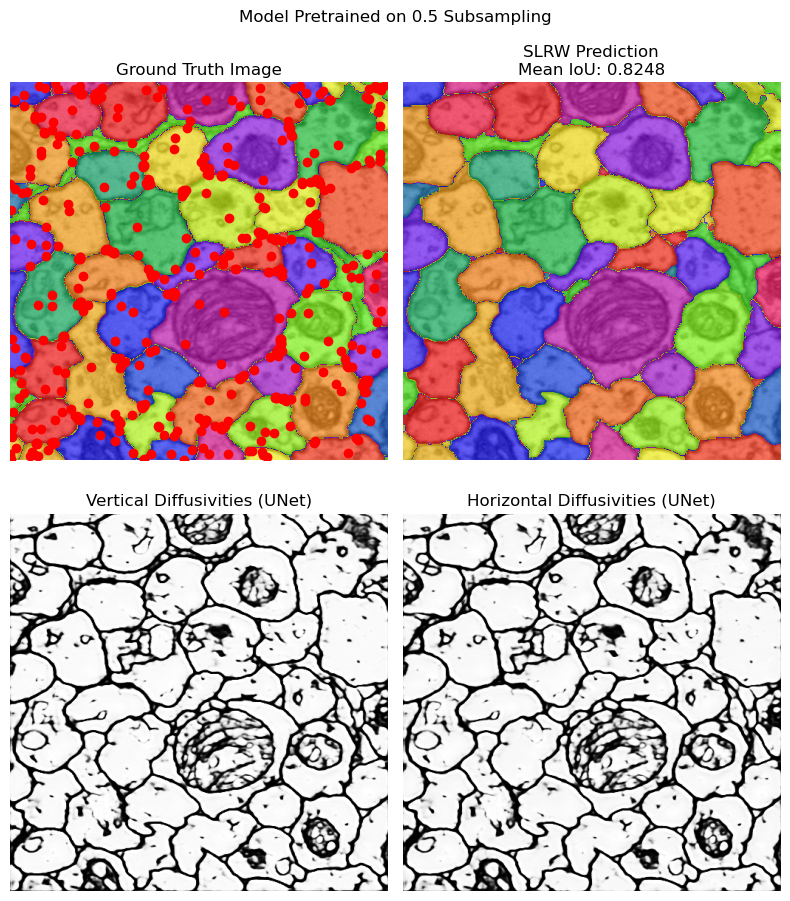

In [27]:
model_path = "checkpoints/models/best_model_20231219_193336_8_0.5"
subsampling_ratio = 0.5
test_pretrained_model(model_path, subsampling_ratio, image_size = 512, image_index = 13)

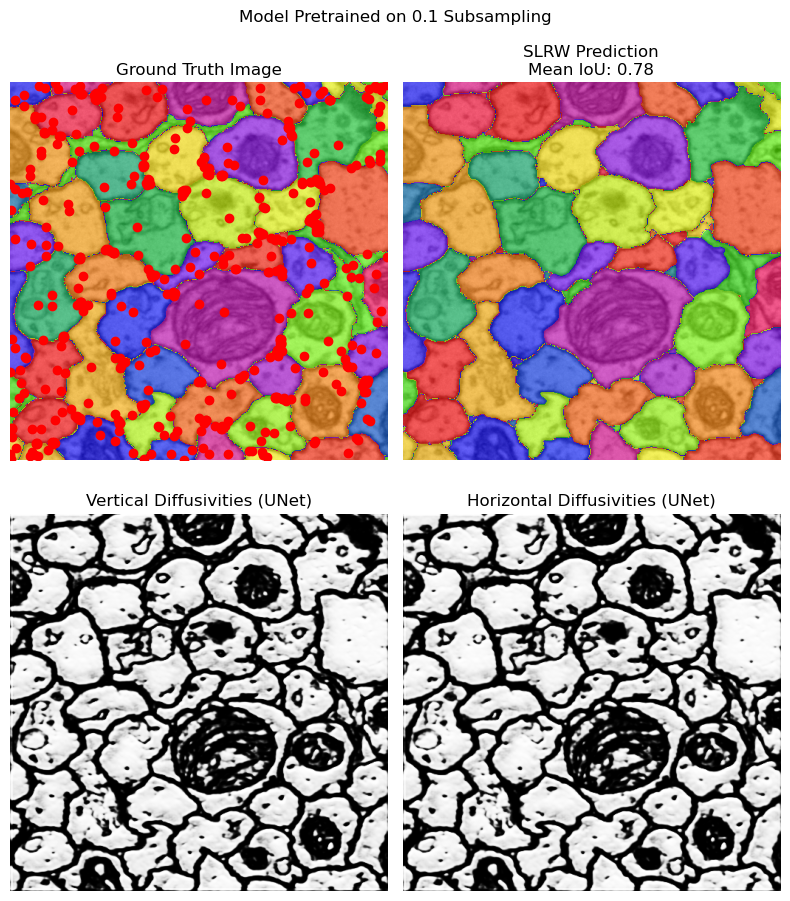

In [24]:
model_path = "checkpoints/models/best_model_20231219_195559_6_0.1"
subsampling_ratio = 0.1
test_pretrained_model(model_path, subsampling_ratio, image_size = 512, image_index = 13)

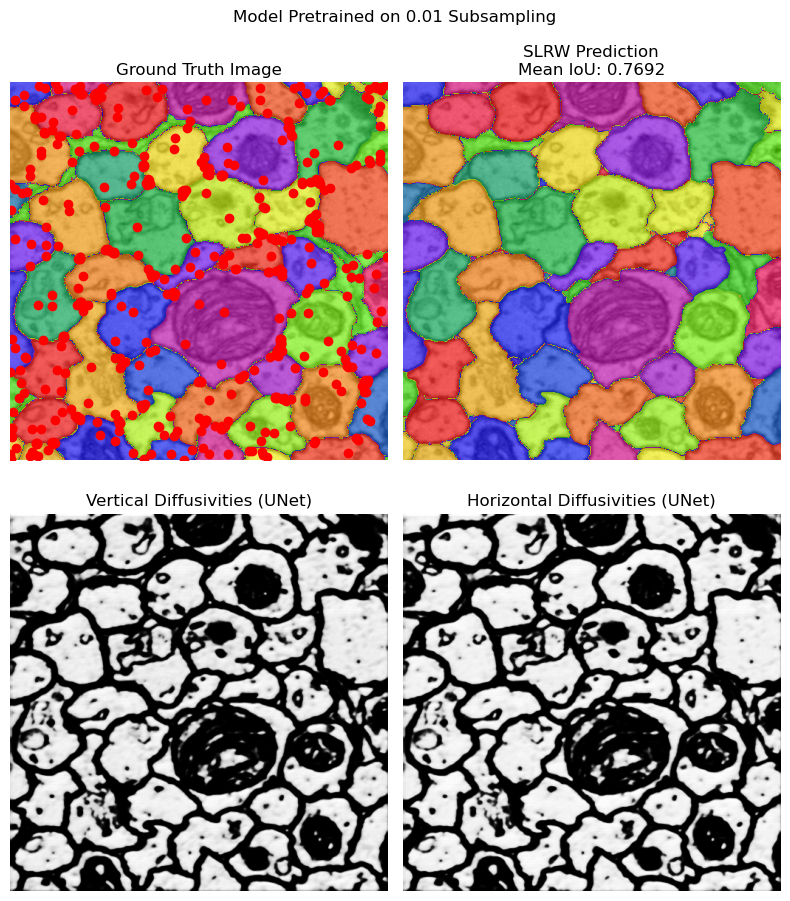

In [28]:
model_path = "checkpoints/models/best_model_20231219_165700_6_0.01"
subsampling_ratio = 0.01
test_pretrained_model(model_path, subsampling_ratio, image_size = 512, image_index = 13)